### Required Modules

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import pickle
import matplotlib.pyplot as plt

### Load Data 

In [3]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data.pkl")

X_train, Y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/validation_data.pkl")

X_val, Y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [4]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

###  Best Neural Network Classifier From Initial Grid Search

**Initial Grid Search Parameters**

Number of nodes: [5,10, 20, 30]

Number of layers: [2,3,4]

In [5]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [6]:
### calculate the number of parameters
def model_params(nodes, n_inputs=15):
    nodes.append(1)
    params = 0
    
    # bottle neck, 0 if model doesn't include a bottle neck and 1 if the model does include one.
    bottle_in = 0
    bottle_hidden = 0
    
    # parameters from models
    for i in range(len(nodes)):
        if i == 0:
            if nodes[i] < n_inputs: bottle_in = 1
            params += n_inputs * nodes[i]
        else:
            params += nodes[i-1]* nodes[i]
            
            if nodes[i-1] < nodes[i]: bottle_hidden = 1
    
    # parameters from biases
    for i in nodes: 
        params += i
    return params, bottle_in, bottle_hidden

In [7]:
assert model_params([2,2])[0] == 41

In [8]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max
val_accs = []
n_params = []
bottle_in = []
bottle_hid = []

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    val_accs.append(val_acc)
    
    n_param, bot_in, bot_hid  = model_params(list(trial['nodes']))
    
    n_params.append(n_param)
    
    bottle_in.append(bot_in)
    bottle_hid.append(bot_hid)
    
    
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial
        
n_params = np.array(n_params)
bottle_in = np.array(bottle_in)
bottle_hid= np.array(bottle_hid)
val_accs = np.array(val_accs)


In [9]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

Best Model

Network: [30 30 30 30] 

Validation accuracy: 0.8433062434196472


Text(0, 0.5, 'Accuracy')

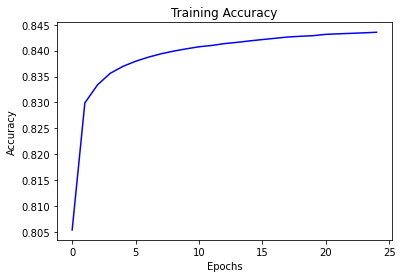

In [10]:
plt.figure()
plt.plot(best_trial["history"]["acc"],color = 'blue')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'MSE')

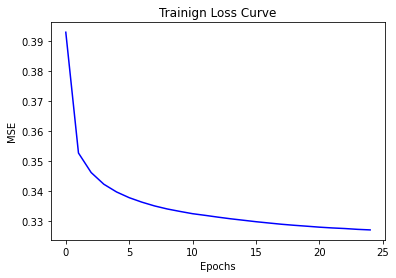

In [11]:
plt.figure()
plt.plot(best_trial["history"]["loss"], color = 'blue')
plt.title("Trainign Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

Text(0, 0.5, 'Frequency')

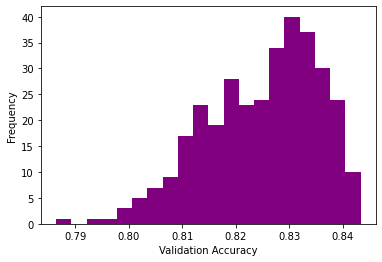

In [12]:
plt.figure()
plt.hist(val_accs, bins = 20, color = 'purple');
plt.xlabel("Validation Accuracy")
plt.ylabel("Frequency")

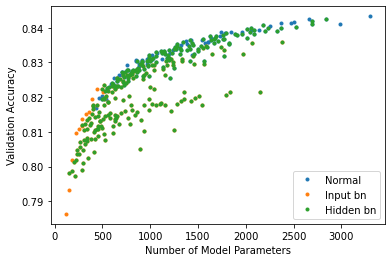

In [41]:
plt.figure()
plt.plot(n_params[np.where(bottle_in == 0)], val_accs[np.where(bottle_in == 0)], '.', label = 'Normal')
plt.plot(n_params[np.where(bottle_in == 1)], val_accs[np.where(bottle_in == 1)], '.', label = 'Input bn')
plt.plot(n_params[np.where(bottle_hid == 1)], val_accs[np.where(bottle_hid == 1)], '.', label = 'Hidden bn')
plt.xlabel("Number of Model Parameters")
plt.ylabel("Validation Accuracy")
plt.legend()

### Grid Search Conclusion

Looking at the plot above we can see that increasing the number of model parameters in general leads to an increase in the models validation accuracy, the graph looks as though it will plateau, but it also suggestes we haven't hit the peak, a further grid search of models with a higher number of parameters should be conducted.

### Final classifier

In [17]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [18]:
model = nn_classifier()

2022-02-01 12:33:58.218682: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-01 12:33:58.348978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 12:33:58.823431: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [20]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =50, callbacks=[stop_early])

2022-02-01 12:35:07.155242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-01 12:35:07.177945: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/50
6523/6523 [==============================] - 141s 20ms/step - loss: 0.4397 - acc: 0.7752 - val_loss: 0.3591 - val_acc: 0.8264
Epoch 2/50
6523/6523 [==============================] - 117s 18ms/step - loss: 0.3545 - acc: 0.8291 - val_loss: 0.3474 - val_acc: 0.8331
Epoch 3/50
6523/6523 [==============================] - 116s 18ms/step - loss: 0.3462 - acc: 0.8334 - val_loss: 0.3434 - val_acc: 0.8351
Epoch 4/50
6523/6523 [==============================] - 116s 18ms/step - loss: 0.3423 - acc: 0.8355 - val_loss: 0.3401 - val_acc: 0.8366
Epoch 5/50
6523/6523 [==============================] - 115s 18ms/step - loss: 0.3397 - acc: 0.8370 - val_loss: 0.3382 - val_acc: 0.8378
Epoch 6/50
6523/6523 [==============================] - 115s 18ms/step - loss: 0.3378 - acc: 0.8378 - val_loss: 0.3370 - val_acc: 0.8379
Epoch 7/50
6523/6523 [==============================] - 117s 18ms/step - loss: 0.3363 - acc: 0.8386 - val_loss: 0.3362 - val_acc: 0.8387
Epoch 8/50
6523/6523 [===================

In [21]:
import matplotlib.pyplot as plt

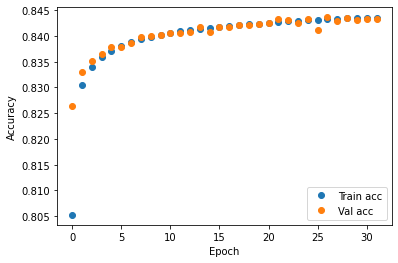

In [22]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

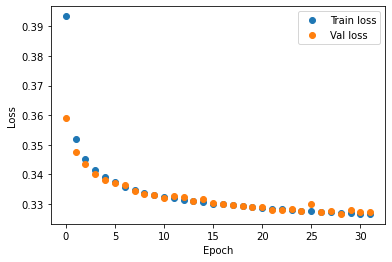

In [23]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [24]:
from sklearn.metrics import roc_curve

In [30]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl")

X_test, Y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [31]:
x_test = scaler.transform(X_test)

In [32]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

In [33]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, predictions)

Text(0.8, 0.2, 'auc =  0.92')

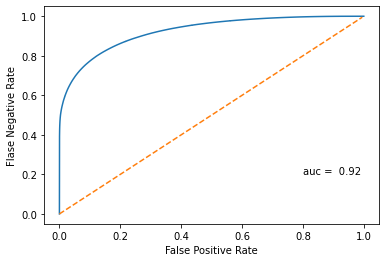

In [34]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

### Distributions from classifier

In [35]:
preds = np.round(predictions).flatten()

In [36]:
no_output = x_test[np.where(preds == 0)]
yes_output = x_test[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [37]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

[b'Ane', b'Ate', b'Autor', b'Machtor', b'x', b'Zeff', b'gammaE', b'q', b'smag', b'alpha', b'Ani1', b'Ati0', b'normni1', b'Ti_Te0', b'logNustar']


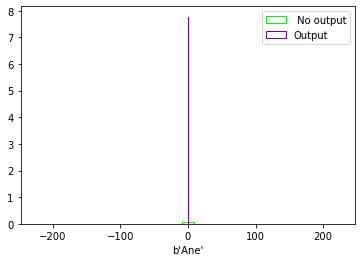

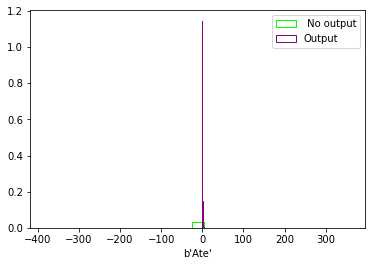

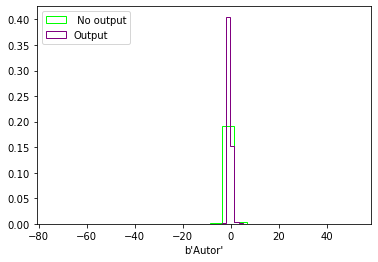

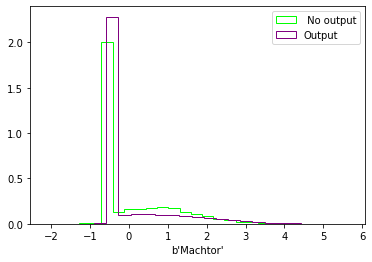

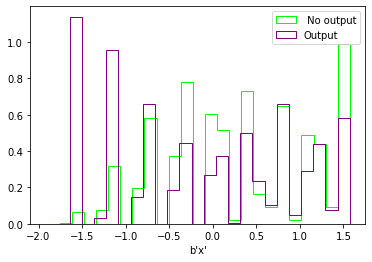

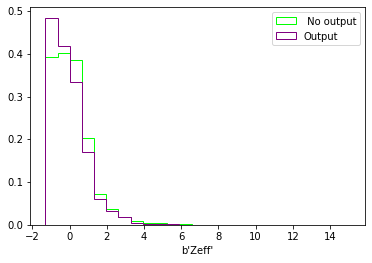

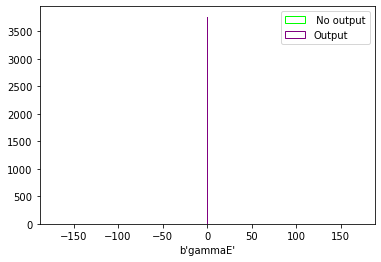

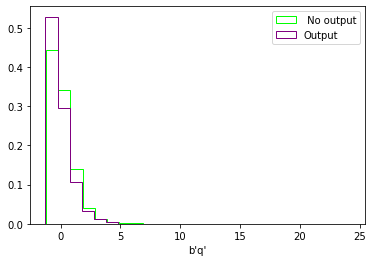

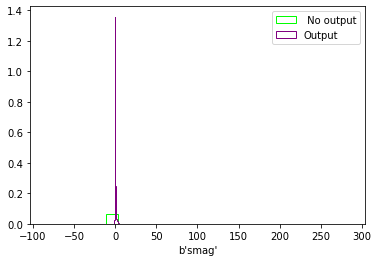

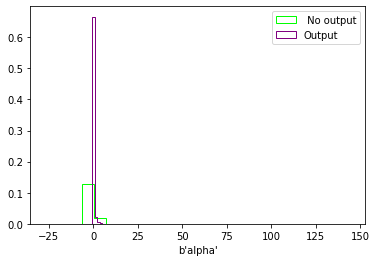

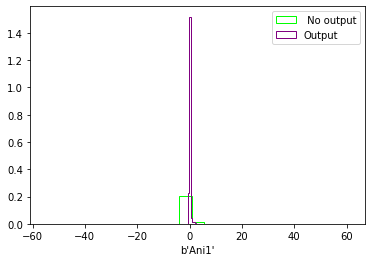

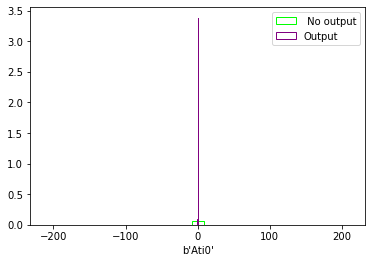

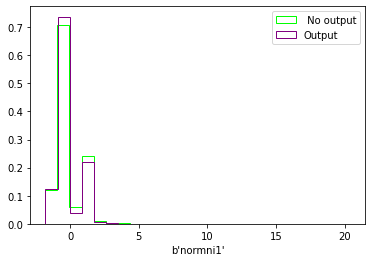

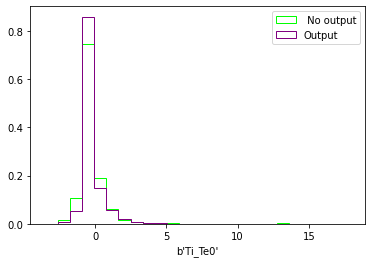

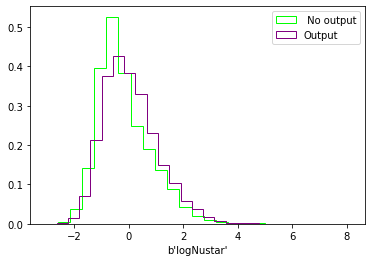

In [39]:
for i, column in enumerate(columns):
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime', label =" No output", density = True, bins =25);
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple', label = "Output", density = True, bins = 25);
    plt.legend()
    plt.xlabel(column)